##Import Libraries

In [14]:
import torch
import torchvision
from torchvision import datasets, transforms
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
from torchsummary import summary
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import seaborn as sns
import matplotlib.pyplot as plt

#### Get cifar10 data stats
*(we are calculating mean and standard deviation for each channel of the input data. We would use this in cutout fillvalue in albumentation transformation, would place it in utils.py file)*

In [15]:
def get_cifar10_stats():
  '''
  we are calculating mean and standard deviation for each channel of the input data. We would use this in cutout fillvalue in albumentation transformation
  '''
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  return train_set.data.mean(axis=(0,1,2))/255, train_set.data.std(axis=(0,1,2))/255

get_cifar10_stats()

Files already downloaded and verified


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

#### Config Data Used
*(Would be part of utils.py file)*

In [16]:
def get_config_values():
  '''
  Returns the config data used
  '''

  dict_config_values = {}
  dict_config_values['dropout_rate'] = 0.01
  dict_config_values['batch_size'] = 256
  dict_config_values['no_of_workers'] = 2
  dict_config_values['pin_memory'] = True
  dict_config_values['learning_rate'] = 0.01
  dict_config_values['epochs'] = 90
  dict_config_values['L1_factor'] = 0
  dict_config_values['L2_factor'] = 0.0001
  dict_config_values['gradient_clip'] = 0.1
  dict_config_values['target_test_accuracy'] = 85

  
  dict_config_values['albumentation'] = {
      'horizontalFlip_probability': 0.2,

      'shiftScaleRotate_shift_limit': 0.1,
      'shiftScaleRotate_scale_limit': 0.1,
      'shiftScaleRotate_rotate_limit': 15,
      'shiftScaleRotate_probability': 0.25,

      'coarseDropout_max_holes': 1,
      'coarseDropout_min_holes': 1,
      'coarseDropout_max_height': 16,
      'coarseDropout_max_width': 16,
      'coarseDropout_min_height': 16,
      'coarseDropout_min_width': 16,
      'coarseDropout_cutout_probability': 0.5,

      'colorJitter_probability': 0.25,
      'colorJitter_brightness': 0.3,
      'colorJitter_contrast': 0.3,
      'colorJitter_saturation': 0.3,
      'colorJitter_hue': 0.2,

      'gray_probability': 0.15
  }
  return dict_config_values

config_dict = get_config_values()

###Data Loaders after applying albumentation transforms
*(would be placed in utils.py file)*

In [17]:
def apply_albumentation(config_dict):
  '''
  Kept separate method to apply albumentation. As it returns the transformation applied in terms of dictionary.
  Our next dataset and dataloaders would use the transformation by calling this method.
  '''
  cifar10_mean,cifar10_std = get_cifar10_stats()

  train_transforms = albumentations.Compose([albumentations.HorizontalFlip(p=config_dict['albumentation']['horizontalFlip_probability']),
                                  albumentations.ShiftScaleRotate(shift_limit=config_dict['albumentation']['shiftScaleRotate_shift_limit'], 
                                                                  scale_limit=config_dict['albumentation']['shiftScaleRotate_scale_limit'],
                                                                  rotate_limit=config_dict['albumentation']['shiftScaleRotate_rotate_limit'],
                                                                  p=config_dict['albumentation']['shiftScaleRotate_probability']),
                                  albumentations.CoarseDropout(max_holes=config_dict['albumentation']['coarseDropout_max_holes'],
                                                               min_holes =config_dict['albumentation']['coarseDropout_min_holes'], 
                                                               max_height=config_dict['albumentation']['coarseDropout_max_height'], 
                                                               max_width=config_dict['albumentation']['coarseDropout_max_width'], 
                                  p=config_dict['albumentation']['coarseDropout_cutout_probability'],fill_value=tuple([x * 255.0 for x in cifar10_mean]),
                                  min_height=config_dict['albumentation']['coarseDropout_min_height'], min_width=config_dict['albumentation']['coarseDropout_min_width']),
                                  albumentations.ColorJitter(p=config_dict['albumentation']['colorJitter_probability'],
                                                             brightness=config_dict['albumentation']['colorJitter_brightness'], 
                                                             contrast=config_dict['albumentation']['colorJitter_contrast'], 
                                                             saturation=config_dict['albumentation']['colorJitter_saturation'], hue=config_dict['albumentation']['colorJitter_hue']),
                                  albumentations.ToGray(p=config_dict['albumentation']['gray_probability']),
                                  albumentations.Normalize(mean=cifar10_mean, std=cifar10_std,always_apply=True),
                                  ToTensorV2()
                                ])

  test_transforms = albumentations.Compose([albumentations.Normalize(mean=cifar10_mean, std=cifar10_std, always_apply=True),
                                 ToTensorV2()])
  return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

def get_data_loaders(config_dict):
  '''
  This method applies albumentation transforms and returns the train and test dataloaders
  : param config_dict: dictionary of config values
  '''
  train_transforms, test_transforms = apply_albumentation(config_dict)  
  

  trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)  
        
  testset  = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transforms)

  train_loader = torch.utils.data.DataLoader(trainset, 
                                                  batch_size=config_dict['batch_size'], 
                                                  shuffle=True,
                                                  num_workers=config_dict['no_of_workers'], 
                                                  pin_memory=config_dict['pin_memory'])
  test_loader = torch.utils.data.DataLoader(testset, 
                                                 batch_size=config_dict['batch_size'], 
                                                  shuffle=True,
                                                  num_workers=config_dict['no_of_workers'], 
                                                  pin_memory=config_dict['pin_memory'])
  return train_loader, test_loader

train_loader, test_loader = get_data_loaders(config_dict)
train_loader, test_loader

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7efcb0c42880>,
 <torch.utils.data.dataloader.DataLoader at 0x7efcb0c429a0>)

##Model
*(placed at Model.py python file, in models directory)*

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    '''
    The class responsible for defining the blocks in the neural network and the forward pass of it
    '''
    def __init__(self, dropout):
        '''

        :param dropout: dropout rate
        '''
        super(Net, self).__init__()

        #------------------------------------Convolution Block 1--------------------------------------------------
        # Input Dimension : 32 * 32 * 3 (32 * 32 color images)
        # Initial Receptive Field: 1
        # Initial Jump-In (jin) : 1
        self.conv1 = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            # Input Dimension : 32 * 32 * 3
            # Output Dimension: (32 + (2 * 1) - 3)/1 + 1 -> 32 * 32 * 32
            # RF Calculation: 1 + (3 - 1) * 1 -> 3 * 3
            # JOut: 1 * 1 = 1

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            # Input Dimension : 32 * 32 * 32
            # Output Dimension: (32 + (2 * 1) - 3)/1 + 1 -> 32 * 32 * 64
            # RF Calculation: 3 + (3 - 1) * 1 -> 5 * 5
            # JOut: 1 * 1 = 1

            nn.Conv2d(64, 32, 1, stride=2),
            nn.ReLU()

            # Input Dimension : 32 * 32 * 64
            # Output Dimension: (32 + (2 * 0) - 1)/2 + 1 -> 16 * 16 * 32
            # RF Calculation: 5 + (1 - 1) * 1 -> 5 * 5
            # JOut: 1 * 2 = 2
            # As per requirement, we have used convolution with stride as 2

        )
        # ------------------------------------------------------------------------------------------------------

        #------------------------------------Convolution Block 2--------------------------------------------------
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            # Input Dimension : 16 * 16 * 32
            # Output Dimension: (16 + (2 * 1) - 3)/1 + 1 -> 16 * 16 * 32
            # RF Calculation: 5 + (3 - 1) * 2 -> 9 * 9
            # JOut: 2 * 1 = 2


            nn.Conv2d(32, 32, 3, padding=1, groups=32, bias=False),

            # Input Dimension : 16 * 16 * 32
            # Output Dimension: (16 + (2 * 1) - 3)/1 + 1 -> 16 * 16 * 32
            # RF Calculation: 9 + (3 - 1) * 2 -> 13 * 13
            # JOut: 2 * 1 = 2
            # We have used depthwise separable convolution

            nn.Conv2d(32, 64, 1, padding=1, bias=False),

            # Input Dimension : 16 * 16 * 32
            # Output Dimension: (16 + (2 * 1) - 1)/1 + 1 -> 18 * 18 * 64
            # RF Calculation: 13 + (1 - 1) * 2 -> 13 * 13
            # JOut: 2 * 1 = 2

            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            nn.Conv2d(64, 32, 1, stride=2),  # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
            nn.ReLU()

            # Input Dimension : 18 * 18 * 64
            # Output Dimension: (18 + (2 * 0) - 1)/2 + 1 -> 9 * 9 * 32
            # RF Calculation: 13 + (1 - 1) * 2 -> 13 * 13
            # JOut: 2 * 2 = 4
        )
        # ------------------------------------------------------------------------------------------------------



        #------------------------------------Convolution Block 3--------------------------------------------------
        self.conv3 = nn.Sequential(

            ## Dilation Block
            nn.Conv2d(32, 64, 3, padding=1, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            # Input Dimension : 9 * 9 * 32
            # Output Dimension: (9 + (2 * 1) - (3 + 2))/1 + 1 -> 7 * 7 * 64
            # RF Calculation: 13 + ((3 + 2) - 1) * 4 -> 29 * 29
            # JOut: 4 * 2 = 8
            # We have used dilation block as per requirement

            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            # Input Dimension : 7 * 7 * 64
            # Output Dimension: (7 + (2 * 1) - 3)/1 + 1 -> 7 * 7 * 64
            # RF Calculation: 29 + (3 - 1) * 8 -> 45 * 45
            # JOut: 8 * 1 = 8

            nn.Conv2d(64, 16, 1, stride=2),  # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
            nn.ReLU()

            # Input Dimension : 7 * 7 * 64
            # Output Dimension: (7 + (2 * 0) - 1)/2 + 1 -> 4 * 4 * 16
            # RF Calculation: 45 + (1 - 1) * 8 -> 45 * 45
            # JOut: 8 * 2 = 16
        )
        # ------------------------------------------------------------------------------------------------------

        #------------------------------------Convolution Block 4--------------------------------------------------
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            # Input Dimension : 4 * 4 * 16
            # Output Dimension: (4 + (2 * 1) - 3)/1 + 1 -> 4 * 4 * 32
            # RF Calculation: 45 + (3 - 1) * 16 -> 77 * 77
            # JOut: 16 * 1 = 16

            ## Depthwise seperable Convolution2
            nn.Conv2d(32, 32, 3, padding=1, groups=32, bias=False),

            # Input Dimension : 4 * 4 * 16
            # Output Dimension: (4 + (2 * 1) - 3)/1 + 1 -> 4 * 4 * 32
            # RF Calculation: 77 + (3 - 1) * 16 -> 109 * 109
            # JOut: 16 * 1 = 16
            # Used Depthwise seperable Convolution as per requirement

            nn.Conv2d(32, 10, 1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(dropout)

            # Input Dimension : 4 * 4 * 32
            # Output Dimension: (4 + (2 * 1) - 1)/1 + 1 -> 6 * 6 * 10
            # RF Calculation: 109 + (1 - 1) * 16 -> 109 * 109
            # JOut: 16 * 1 = 16
        )
        # ------------------------------------------------------------------------------------------------------

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        '''

        :param x: Input
        :return: Log softmax output
        '''
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

##Generating Torchsummary and Number of Model Parameters

In [19]:
def print_model_summary(model, device):
    '''
      THis method returns the model summary.

      :param model: model
      :param device: device
    '''
    cifar_model = model.to(device)
    return summary(cifar_model, input_size=(3, 32, 32))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print_model_summary(Net(dropout = 0.01), device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           2,080
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

### Train Code
*(Would be placed in train.py file)*

In [20]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,l1_factor,scheduler,criterion,grad_clip=None):
  '''
  This method is responsible for model training

  :param model: model
  :param device: cuda (gpu) or cpu
  :param train_loader: train loader
  :param optimizer: Optimizer, for example, Adam, or SGD
  :param epoch: epoch, the number of times we are seeing the entire training data
  :param train_acc: training accuracy
  :param train_loss: training loss
  :param l1_factor: L1 Factor
  :param scheduler: scheduler
  :param criterion: criterion
  :param grad_clip: gradient clipping value
  '''

  model.train()
  pbar = tqdm(train_loader)
  correct, processed = 0, 0
  
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    
    if l1_factor > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + l1_factor*l1

    train_loss.append(loss.data.cpu().numpy().item())
    loss.backward()

    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

###Test Code
*(Would be placed in test.py file)*

In [21]:
def test(model, device, test_loader,test_acc,test_losses,criterion):

  '''
  This method is responsible for model testing
  :param model: model
  :param device: device, cuda (gpu), or cpu
  :param test_loader: test loader
  :param test_acc: test accuracy
  :param test_losses: test losses
  :param criterion: criterion
  '''
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()
          pred = output.argmax(dim=1, keepdim=True)  
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))
  return 100. * correct / len(test_loader.dataset)

###Optimizer and Scheduler
*(Would be placed the relevant code in utils.py)*

In [22]:
def get_optimizer(config_dict, model):
  '''
  This method returns the optimizer
  :param config_dict: config dictionary
  :param model: model
  '''
  return optim.Adam(model.parameters(), lr=config_dict['learning_rate'], weight_decay=config_dict['L2_factor'])

def get_scheduler(train_loader, config_dict, model):
  '''
  This method returns the scheduler
  :param train_loader: train loader
  :param config_dict: config dictionary
  :param model: model
  '''
  optimizer = get_optimizer(config_dict, model)
  return OneCycleLR(optimizer, max_lr=config_dict['learning_rate'],epochs=config_dict['epochs'],steps_per_epoch=len(train_loader)), optimizer

### Available device for use
*(Would be part of utils.py file)*

In [23]:
def get_device():
  '''
  This method returns the device in use.
  If cuda(gpu) is available it would return that, otherwise it would return cpu.
  '''
  use_cuda = torch.cuda.is_available()
  return torch.device("cuda" if use_cuda else "cpu")


### Experiment
*(Would be part of experiment.py file)*

In [24]:
def experiment(config_dict, train_loader, test_loader):
  '''
  The method performs the experiment as per our configuration.
  To preserve gpu usage, we are exiting while we reach the target validation accuracy.
  '''

  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []

  device = get_device()
  model = Net(config_dict['dropout_rate']).to(device)
  scheduler, optimizer = get_scheduler(train_loader, config_dict, model)

  for epoch in range(1, config_dict['epochs'] + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer,epoch, train_accuracy, train_losses, config_dict['L1_factor'],
          scheduler,nn.CrossEntropyLoss(),config_dict['gradient_clip'])

    test_accuracy_local = test(model, device, test_loader,test_accuracy,test_losses,nn.CrossEntropyLoss())

    if test_accuracy_local >= config_dict['target_test_accuracy']:
      return (train_accuracy,train_losses,test_accuracy,test_losses)

  return (train_accuracy,train_losses,test_accuracy,test_losses)

In [25]:
experiment_results = experiment(config_dict, train_loader, test_loader)

Epoch 1:


Loss=1.9371486902236938 Batch_id=195 Accuracy=29.61: 100%|██████████| 196/196 [00:16<00:00, 12.12it/s]



Test set: Average loss: 0.0068, Accuracy: 4361/10000 (43.61%)

Epoch 2:


Loss=1.7106716632843018 Batch_id=195 Accuracy=41.54: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]



Test set: Average loss: 0.0060, Accuracy: 5139/10000 (51.39%)

Epoch 3:


Loss=1.5164453983306885 Batch_id=195 Accuracy=48.18: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0053, Accuracy: 5709/10000 (57.09%)

Epoch 4:


Loss=1.2748647928237915 Batch_id=195 Accuracy=53.26: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0049, Accuracy: 6098/10000 (60.98%)

Epoch 5:


Loss=1.2323343753814697 Batch_id=195 Accuracy=56.88: 100%|██████████| 196/196 [00:16<00:00, 12.21it/s]



Test set: Average loss: 0.0043, Accuracy: 6571/10000 (65.71%)

Epoch 6:


Loss=1.280673623085022 Batch_id=195 Accuracy=59.32: 100%|██████████| 196/196 [00:16<00:00, 12.00it/s]



Test set: Average loss: 0.0043, Accuracy: 6530/10000 (65.30%)

Epoch 7:


Loss=1.2698378562927246 Batch_id=195 Accuracy=61.85: 100%|██████████| 196/196 [00:16<00:00, 12.11it/s]



Test set: Average loss: 0.0038, Accuracy: 6942/10000 (69.42%)

Epoch 8:


Loss=1.017128825187683 Batch_id=195 Accuracy=63.38: 100%|██████████| 196/196 [00:16<00:00, 12.20it/s]



Test set: Average loss: 0.0036, Accuracy: 7053/10000 (70.53%)

Epoch 9:


Loss=1.0090224742889404 Batch_id=195 Accuracy=64.97: 100%|██████████| 196/196 [00:15<00:00, 12.28it/s]



Test set: Average loss: 0.0036, Accuracy: 7035/10000 (70.35%)

Epoch 10:


Loss=1.0494353771209717 Batch_id=195 Accuracy=65.98: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]



Test set: Average loss: 0.0036, Accuracy: 7026/10000 (70.26%)

Epoch 11:


Loss=0.9911742210388184 Batch_id=195 Accuracy=66.69: 100%|██████████| 196/196 [00:16<00:00, 11.94it/s]



Test set: Average loss: 0.0033, Accuracy: 7216/10000 (72.16%)

Epoch 12:


Loss=1.1618266105651855 Batch_id=195 Accuracy=67.42: 100%|██████████| 196/196 [00:16<00:00, 12.04it/s]



Test set: Average loss: 0.0032, Accuracy: 7337/10000 (73.37%)

Epoch 13:


Loss=0.9455658793449402 Batch_id=195 Accuracy=67.71: 100%|██████████| 196/196 [00:17<00:00, 11.07it/s]



Test set: Average loss: 0.0033, Accuracy: 7281/10000 (72.81%)

Epoch 14:


Loss=1.0856261253356934 Batch_id=195 Accuracy=68.13: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0030, Accuracy: 7541/10000 (75.41%)

Epoch 15:


Loss=0.9132341146469116 Batch_id=195 Accuracy=68.76: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0033, Accuracy: 7220/10000 (72.20%)

Epoch 16:


Loss=0.805076003074646 Batch_id=195 Accuracy=69.42: 100%|██████████| 196/196 [00:16<00:00, 11.96it/s]



Test set: Average loss: 0.0028, Accuracy: 7569/10000 (75.69%)

Epoch 17:


Loss=0.7440102100372314 Batch_id=195 Accuracy=69.56: 100%|██████████| 196/196 [00:16<00:00, 12.01it/s]



Test set: Average loss: 0.0030, Accuracy: 7503/10000 (75.03%)

Epoch 18:


Loss=0.9029043316841125 Batch_id=195 Accuracy=69.53: 100%|██████████| 196/196 [00:16<00:00, 11.67it/s]



Test set: Average loss: 0.0030, Accuracy: 7465/10000 (74.65%)

Epoch 19:


Loss=0.7610498666763306 Batch_id=195 Accuracy=69.84: 100%|██████████| 196/196 [00:16<00:00, 11.67it/s]



Test set: Average loss: 0.0030, Accuracy: 7493/10000 (74.93%)

Epoch 20:


Loss=0.7394888997077942 Batch_id=195 Accuracy=70.00: 100%|██████████| 196/196 [00:17<00:00, 11.53it/s]



Test set: Average loss: 0.0028, Accuracy: 7668/10000 (76.68%)

Epoch 21:


Loss=1.1128368377685547 Batch_id=195 Accuracy=70.47: 100%|██████████| 196/196 [00:16<00:00, 11.66it/s]



Test set: Average loss: 0.0031, Accuracy: 7371/10000 (73.71%)

Epoch 22:


Loss=0.9401184916496277 Batch_id=195 Accuracy=70.49: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0029, Accuracy: 7527/10000 (75.27%)

Epoch 23:


Loss=0.7843496799468994 Batch_id=195 Accuracy=70.72: 100%|██████████| 196/196 [00:16<00:00, 11.59it/s]



Test set: Average loss: 0.0029, Accuracy: 7568/10000 (75.68%)

Epoch 24:


Loss=0.7335059642791748 Batch_id=195 Accuracy=70.81: 100%|██████████| 196/196 [00:16<00:00, 11.79it/s]



Test set: Average loss: 0.0034, Accuracy: 7188/10000 (71.88%)

Epoch 25:


Loss=1.1092424392700195 Batch_id=195 Accuracy=71.02: 100%|██████████| 196/196 [00:17<00:00, 10.91it/s]



Test set: Average loss: 0.0032, Accuracy: 7402/10000 (74.02%)

Epoch 26:


Loss=1.0462005138397217 Batch_id=195 Accuracy=71.05: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0028, Accuracy: 7639/10000 (76.39%)

Epoch 27:


Loss=1.0045673847198486 Batch_id=195 Accuracy=71.14: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0026, Accuracy: 7735/10000 (77.35%)

Epoch 28:


Loss=0.8853341341018677 Batch_id=195 Accuracy=71.27: 100%|██████████| 196/196 [00:16<00:00, 11.98it/s]



Test set: Average loss: 0.0027, Accuracy: 7647/10000 (76.47%)

Epoch 29:


Loss=0.9365090131759644 Batch_id=195 Accuracy=71.17: 100%|██████████| 196/196 [00:16<00:00, 11.78it/s]



Test set: Average loss: 0.0028, Accuracy: 7673/10000 (76.73%)

Epoch 30:


Loss=0.916951060295105 Batch_id=195 Accuracy=71.50: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0030, Accuracy: 7444/10000 (74.44%)

Epoch 31:


Loss=1.0645740032196045 Batch_id=195 Accuracy=71.37: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0028, Accuracy: 7599/10000 (75.99%)

Epoch 32:


Loss=1.024559736251831 Batch_id=195 Accuracy=71.75: 100%|██████████| 196/196 [00:16<00:00, 11.77it/s]



Test set: Average loss: 0.0033, Accuracy: 7246/10000 (72.46%)

Epoch 33:


Loss=0.9699963331222534 Batch_id=195 Accuracy=71.66: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0028, Accuracy: 7629/10000 (76.29%)

Epoch 34:


Loss=0.8779830932617188 Batch_id=195 Accuracy=71.98: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0026, Accuracy: 7665/10000 (76.65%)

Epoch 35:


Loss=0.7946022748947144 Batch_id=195 Accuracy=71.52: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0031, Accuracy: 7438/10000 (74.38%)

Epoch 36:


Loss=0.8246749043464661 Batch_id=195 Accuracy=71.94: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0028, Accuracy: 7632/10000 (76.32%)

Epoch 37:


Loss=0.8907915353775024 Batch_id=195 Accuracy=71.92: 100%|██████████| 196/196 [00:17<00:00, 10.91it/s]



Test set: Average loss: 0.0030, Accuracy: 7517/10000 (75.17%)

Epoch 38:


Loss=0.8354768753051758 Batch_id=195 Accuracy=72.15: 100%|██████████| 196/196 [00:16<00:00, 11.71it/s]



Test set: Average loss: 0.0025, Accuracy: 7892/10000 (78.92%)

Epoch 39:


Loss=0.8708763122558594 Batch_id=195 Accuracy=72.14: 100%|██████████| 196/196 [00:16<00:00, 11.77it/s]



Test set: Average loss: 0.0027, Accuracy: 7754/10000 (77.54%)

Epoch 40:


Loss=0.738598644733429 Batch_id=195 Accuracy=72.46: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0026, Accuracy: 7822/10000 (78.22%)

Epoch 41:


Loss=0.7667247653007507 Batch_id=195 Accuracy=72.83: 100%|██████████| 196/196 [00:16<00:00, 11.77it/s]



Test set: Average loss: 0.0026, Accuracy: 7737/10000 (77.37%)

Epoch 42:


Loss=1.013182282447815 Batch_id=195 Accuracy=72.69: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0027, Accuracy: 7702/10000 (77.02%)

Epoch 43:


Loss=0.92280513048172 Batch_id=195 Accuracy=72.81: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0030, Accuracy: 7523/10000 (75.23%)

Epoch 44:


Loss=0.8970339894294739 Batch_id=195 Accuracy=73.08: 100%|██████████| 196/196 [00:16<00:00, 11.88it/s]



Test set: Average loss: 0.0025, Accuracy: 7903/10000 (79.03%)

Epoch 45:


Loss=0.6552590131759644 Batch_id=195 Accuracy=72.96: 100%|██████████| 196/196 [00:16<00:00, 11.75it/s]



Test set: Average loss: 0.0024, Accuracy: 7978/10000 (79.78%)

Epoch 46:


Loss=0.8169801831245422 Batch_id=195 Accuracy=73.31: 100%|██████████| 196/196 [00:16<00:00, 11.73it/s]



Test set: Average loss: 0.0024, Accuracy: 7930/10000 (79.30%)

Epoch 47:


Loss=0.8236644864082336 Batch_id=195 Accuracy=73.69: 100%|██████████| 196/196 [00:16<00:00, 11.69it/s]



Test set: Average loss: 0.0024, Accuracy: 7954/10000 (79.54%)

Epoch 48:


Loss=0.9900811314582825 Batch_id=195 Accuracy=73.46: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0024, Accuracy: 7984/10000 (79.84%)

Epoch 49:


Loss=0.8291366696357727 Batch_id=195 Accuracy=74.04: 100%|██████████| 196/196 [00:17<00:00, 10.94it/s]



Test set: Average loss: 0.0027, Accuracy: 7737/10000 (77.37%)

Epoch 50:


Loss=0.6869806051254272 Batch_id=195 Accuracy=73.99: 100%|██████████| 196/196 [00:16<00:00, 11.59it/s]



Test set: Average loss: 0.0024, Accuracy: 7911/10000 (79.11%)

Epoch 51:


Loss=0.7001036405563354 Batch_id=195 Accuracy=74.43: 100%|██████████| 196/196 [00:16<00:00, 11.67it/s]



Test set: Average loss: 0.0022, Accuracy: 8118/10000 (81.18%)

Epoch 52:


Loss=0.7368819713592529 Batch_id=195 Accuracy=74.44: 100%|██████████| 196/196 [00:16<00:00, 11.60it/s]



Test set: Average loss: 0.0024, Accuracy: 7932/10000 (79.32%)

Epoch 53:


Loss=0.7317963242530823 Batch_id=195 Accuracy=74.60: 100%|██████████| 196/196 [00:16<00:00, 11.63it/s]



Test set: Average loss: 0.0023, Accuracy: 8031/10000 (80.31%)

Epoch 54:


Loss=0.5556869506835938 Batch_id=195 Accuracy=74.85: 100%|██████████| 196/196 [00:16<00:00, 11.82it/s]



Test set: Average loss: 0.0022, Accuracy: 8098/10000 (80.98%)

Epoch 55:


Loss=1.094988465309143 Batch_id=195 Accuracy=75.23: 100%|██████████| 196/196 [00:16<00:00, 11.76it/s]



Test set: Average loss: 0.0022, Accuracy: 8106/10000 (81.06%)

Epoch 56:


Loss=0.6839620471000671 Batch_id=195 Accuracy=75.13: 100%|██████████| 196/196 [00:16<00:00, 11.83it/s]



Test set: Average loss: 0.0023, Accuracy: 8090/10000 (80.90%)

Epoch 57:


Loss=0.7589752078056335 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:16<00:00, 12.03it/s]



Test set: Average loss: 0.0024, Accuracy: 8035/10000 (80.35%)

Epoch 58:


Loss=0.7050309777259827 Batch_id=195 Accuracy=75.82: 100%|██████████| 196/196 [00:16<00:00, 12.03it/s]



Test set: Average loss: 0.0023, Accuracy: 8074/10000 (80.74%)

Epoch 59:


Loss=0.5596480965614319 Batch_id=195 Accuracy=76.24: 100%|██████████| 196/196 [00:16<00:00, 11.86it/s]



Test set: Average loss: 0.0021, Accuracy: 8215/10000 (82.15%)

Epoch 60:


Loss=0.7529387474060059 Batch_id=195 Accuracy=76.55: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0020, Accuracy: 8196/10000 (81.96%)

Epoch 61:


Loss=0.6616877913475037 Batch_id=195 Accuracy=76.52: 100%|██████████| 196/196 [00:17<00:00, 11.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8246/10000 (82.46%)

Epoch 62:


Loss=0.5258587598800659 Batch_id=195 Accuracy=77.19: 100%|██████████| 196/196 [00:16<00:00, 11.72it/s]



Test set: Average loss: 0.0020, Accuracy: 8310/10000 (83.10%)

Epoch 63:


Loss=0.8879419565200806 Batch_id=195 Accuracy=77.40: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0020, Accuracy: 8322/10000 (83.22%)

Epoch 64:


Loss=0.8439589738845825 Batch_id=195 Accuracy=77.55: 100%|██████████| 196/196 [00:16<00:00, 11.68it/s]



Test set: Average loss: 0.0019, Accuracy: 8395/10000 (83.95%)

Epoch 65:


Loss=0.6423452496528625 Batch_id=195 Accuracy=77.89: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0019, Accuracy: 8377/10000 (83.77%)

Epoch 66:


Loss=0.6325924396514893 Batch_id=195 Accuracy=78.18: 100%|██████████| 196/196 [00:16<00:00, 11.93it/s]



Test set: Average loss: 0.0019, Accuracy: 8398/10000 (83.98%)

Epoch 67:


Loss=0.6742538213729858 Batch_id=195 Accuracy=78.79: 100%|██████████| 196/196 [00:16<00:00, 11.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8390/10000 (83.90%)

Epoch 68:


Loss=0.7806583046913147 Batch_id=195 Accuracy=79.01: 100%|██████████| 196/196 [00:16<00:00, 11.59it/s]



Test set: Average loss: 0.0018, Accuracy: 8464/10000 (84.64%)

Epoch 69:


Loss=0.5567256808280945 Batch_id=195 Accuracy=79.12: 100%|██████████| 196/196 [00:16<00:00, 11.74it/s]



Test set: Average loss: 0.0019, Accuracy: 8436/10000 (84.36%)

Epoch 70:


Loss=0.65577232837677 Batch_id=195 Accuracy=79.57: 100%|██████████| 196/196 [00:16<00:00, 11.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8482/10000 (84.82%)

Epoch 71:


Loss=0.5376607775688171 Batch_id=195 Accuracy=80.07: 100%|██████████| 196/196 [00:16<00:00, 11.81it/s]



Test set: Average loss: 0.0018, Accuracy: 8520/10000 (85.20%)



### Plotting Validation Loss & Accuracy

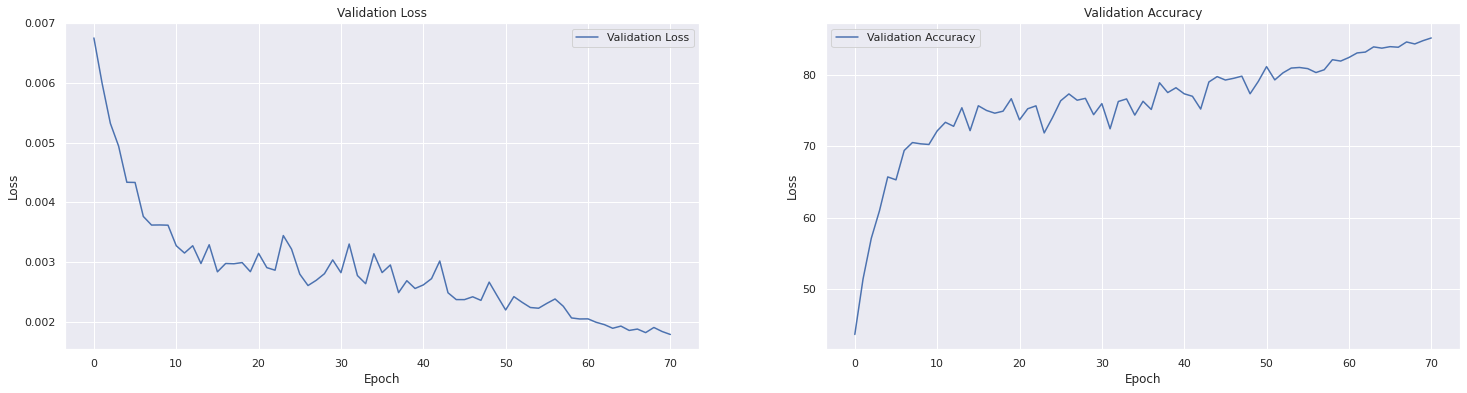

In [26]:
def plot_metrics(experiment_results):

  '''
  This method plots Validation Loss & Accuracy progression.
  :param experiment_results: Experiment Results interms of training and testing loss and accuracy
  '''
  sns.set(font_scale=1)
  plt.rcParams["figure.figsize"] = (25,6)
  train_accuracy,train_losses,test_accuracy,test_losses  = experiment_results[0], experiment_results[1], experiment_results[2], experiment_results[3]
  
  # Plot the learning curve.
  fig, (ax1,ax2) = plt.subplots(1,2)
  ax1.plot(np.array(test_losses), 'b', label="Validation Loss")
  
  # Label the plot.
  ax1.set_title("Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()
  
  ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")
  
  # Label the plot.
  ax2.set_title("Validation Accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.legend()
  
plot_metrics(experiment_results)